<a href="https://colab.research.google.com/github/britaniatorsulu/202055202084-Wastitorsulu/blob/master/Tubes_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection menggunakan YOLOv5

<img src="https://storage.googleapis.com/wandb-production.appspot.com/wandb-public-images/3hql0qh3b7.png"/>

<br/>
<br/>
Anggota Kelompok:
<div>
<table align="left">
  <tr>
    <td>Wasti Britania Torsulu</td>
    <td>202055202084</td>
  </tr>
  <tr>
    <td>Fira Aliah</td>
    <td>202055202088</td>
  </tr>
</table>
</div>


#0. Persiapan Dataset

Dataset yang akan digunakan adalah [andrewmvd/face-mask-detection](https://www.kaggle.com/andrewmvd/face-mask-detection) dari Kaggle.

## Kaggle API

Install kaggle package menggunakan pip

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Upload `kaggle.json` yang berisi *API key*

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"wastibritaniatorsulu","key":"52e308c1c8c8a40cc9b01135ebb68949"}'}

Pindahkan `kaggle.json` ke dalam folder `~/.kaggle` agar dapat dieksekusi oleh system.

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Aktifkan Google Drive dan buat folder `face_mask_detection`

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Jalankan ini jika ingin clone ulang `YOLOv5`

In [6]:
#!rm -r /content/drive/MyDrive/face_mask_detection/yolov5

In [7]:
!mkdir -p /content/drive/MyDrive/face_mask_detection
%cd /content/drive/MyDrive/face_mask_detection

/content/drive/MyDrive/face_mask_detection


Download dataset menggunakan *API command*

In [8]:
!kaggle datasets download -d andrewmvd/face-mask-detection

100% 397M/398M [00:18<00:00, 21.3MB/s]
100% 398M/398M [00:18<00:00, 22.5MB/s]


Unzip dataset menjadi folder

In [9]:
!unzip -qq /content/drive/MyDrive/face_mask_detection/face-mask-detection.zip

## Memahami Format Anotasi

Struktur anotasi dengan format PASCAL VOC dari dataset

In [10]:
!cat /content/drive/MyDrive/face_mask_detection/annotations/maksssksksss0.xml


<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</

Periksa total kategori/class pada anotasi *ground-truth* dari dataset

In [11]:
import xml.etree.ElementTree as ET
from glob import glob

ANNOTATION_DIR = '/content/drive/MyDrive/face_mask_detection/annotations'

annotation_paths = glob(ANNOTATION_DIR + '/*.xml')
print(f'Jumlah file anotasi xml: {len(annotation_paths)}')

amount_per_class = {}

for path in annotation_paths:
  root = ET.parse(path).getroot()

  for name in root.findall('object/name'):
    if name.text not in amount_per_class.keys():
      amount_per_class[name.text] = 1
    else:
      amount_per_class[name.text] += 1

print(f'Jumlah objek per class: {amount_per_class}')

Jumlah file anotasi xml: 853
Jumlah objek per class: {'without_mask': 717, 'with_mask': 3232, 'mask_weared_incorrect': 123}


Mengubah anotasi format PASCAL VOC .xml menjadi Darknet YOLO .txt

PASCAL VOC:
```
<object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
</object>
```

Struktur anotasi Darknet YOLO adalah:
```
class_code x_center y_center bbox_width bbox_height
```

<img src="https://user-images.githubusercontent.com/26833433/91506361-c7965000-e886-11ea-8291-c72b98c25eec.jpg" width="500px" />

Perlu diingat bahwa semua nilai koordinat horizontal `x_center` dan `bbox_width` dibagi dengan `img_width` dan koordinat vertikal `y_center` dan `bbox_height` dibagi dengan `img_height`.

Untuk mendapatkan `img_width` dan `img_height` pada PASCAL VOC kita bisa mengambil nilainya pada:
```
<size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
</size>
```

Konversi nilai dari PASCAL VOC ke Darknet YOLO
- `class_code`: dimulai dari 0 sampai seterusnya, seperti contoh berikut.
```
{'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}
```
- `x_center = ((xmin + xmax) / 2) / img_width`
- `y_center = ((ymin + ymax) / 2) / img_height`
- `bbox_width = (xmax - xmin) / img_width`
- `bbox_height = (ymax - ymin) / img_height`

Sehingga, bentuk anotasi Darknet YOLO dari PASCAL VOC sebelumnya adalah sebagai berikut:
```
0 0.4013671875 0.3333333333 0.080078125 0.1202185792
```

## Konversi Format Anotasi

Script untuk melakukan konversi pada semua file .xml anotasi PASCAL VOC menjadi .txt Darknet YOLO

In [12]:
import xml.etree.ElementTree as ET
from glob import glob
from tqdm import tqdm
import os

PASCAL_VOC_ANNOTATION_DIR = '/content/drive/MyDrive/face_mask_detection/annotations'
YOLO_ANNOTATION_DIR = '/content/drive/MyDrive/face_mask_detection/yolo_annotations'
class_codes = {'with_mask': 0, 'without_mask': 1, 'mask_weared_incorrect': 2}

if not os.path.exists(YOLO_ANNOTATION_DIR):
  os.makedirs(YOLO_ANNOTATION_DIR)

pascal_voc_annotation_paths = glob(PASCAL_VOC_ANNOTATION_DIR + '/*.xml')

for xml_path in tqdm(pascal_voc_annotation_paths, desc='Converting PASCAL VOC to YOLO Darknet Annotations'):
  root = ET.parse(xml_path).getroot()

  img_width = float(root.find('size/width').text)
  img_height = float(root.find('size/height').text)

  yolo_annotation_filename = os.path.basename(xml_path)[:-4] + '.txt'
  yolo_annotation_path = os.path.join(YOLO_ANNOTATION_DIR, yolo_annotation_filename)

  with open(yolo_annotation_path, 'w') as f:

    annotation_strings = []

    for object_childs in root.findall('object'):

      class_code = class_codes[object_childs.find('name').text]

      xmin = float(object_childs.find('bndbox/xmin').text)
      xmax = float(object_childs.find('bndbox/xmax').text)
      ymin = float(object_childs.find('bndbox/ymin').text)
      ymax = float(object_childs.find('bndbox/ymax').text)

      x_center = ((xmin + xmax) / 2) / img_width
      y_center = ((ymin + ymax) / 2) / img_height
      bbox_width = (xmax - xmin) / img_width
      bbox_height = (ymax - ymin) / img_height

      annotation_strings.append(f'{class_code} {x_center} {y_center} {bbox_width} {bbox_height}')

    f.write('\n'.join(annotation_strings))

Converting PASCAL VOC to YOLO Darknet Annotations: 100%|██████████| 853/853 [00:04<00:00, 179.29it/s]


## Membagi Train dan Validation Dataset

Split dataset menjadi `train` dan `validation`

In [13]:
%cd /content/drive/MyDrive/face_mask_detection
!mkdir -p 'dataset/images/train'
!mkdir -p 'dataset/images/validation'
!mkdir -p 'dataset/labels/train'
!mkdir -p 'dataset/labels/validation'

/content/drive/MyDrive/face_mask_detection


In [14]:
import shutil
import random

%cd /content/drive/MyDrive/face_mask_detection

validation_split = 0.2

IMAGES_DIR = 'images'
LABELS_DIR = 'yolo_annotations'

IMAGES_TRAIN_DIR = 'dataset/images/train'
IMAGES_VALIDATION_DIR = 'dataset/images/validation'

LABELS_TRAIN_DIR = 'dataset/labels/train'
LABELS_VALIDATION_DIR = 'dataset/labels/validation'

image_paths = glob(IMAGES_DIR + '/*.png')
random.Random(42).shuffle(image_paths)

count_train = 0
count_validation = 0

for idx, image_path in enumerate(image_paths):

  label_path = LABELS_DIR + '/' + os.path.basename(image_path)[:-4] + '.txt'

  if idx < int(len(image_paths) * (1 - validation_split)):
    shutil.copy(image_path, IMAGES_TRAIN_DIR)
    shutil.copy(label_path, LABELS_TRAIN_DIR)
    count_train += 1
  else:
    shutil.copy(image_path, IMAGES_VALIDATION_DIR)
    shutil.copy(label_path, LABELS_VALIDATION_DIR)
    count_validation += 1

print(f'Train data: {count_train}')
print(f'Validation data: {count_validation}')

/content/drive/MyDrive/face_mask_detection
Train data: 682
Validation data: 171


Menghapus folder dan file yang tidak lagi diperlukan

In [15]:
%cd /content/drive/MyDrive/face_mask_detection
!rm -r annotations images yolo_annotations
!rm face-mask-detection.zip

/content/drive/MyDrive/face_mask_detection


#1. Training Custom Data meggunakan YOLOv5

Gunakan *source code* YOLOv5 yang ada pada Github *repository* berikut [ultralytics/yolov5](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)

## Persiapan *working directory* dan *training resources*

Clone *source code* YOLOv5 dari Github.

In [16]:
%cd /content/drive/MyDrive/face_mask_detection
!git clone https://github.com/ultralytics/yolov5

/content/drive/MyDrive/face_mask_detection
Cloning into 'yolov5'...
remote: Enumerating objects: 15935, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 15935 (delta 65), reused 87 (delta 58), pack-reused 15831
Receiving objects: 100% (15935/15935), 14.53 MiB | 12.58 MiB/s, done.
Resolving deltas: 100% (10939/10939), done.


Sekarang, folder `face_mask_detection` akan terlihat seperti ini:

```
face_mask_detection
  > dataset
  > yolov5
```

Ubah *working directory* pada `yolov5` dan install semua *package* yang dibutuhkan. Daftar *package* yang dibutuhkan, terdapat pada file `requirements.txt`.

In [17]:
%cd /content/drive/MyDrive/face_mask_detection/yolov5
!pip install -r requirements.txt

/content/drive/MyDrive/face_mask_detection/yolov5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.1/593.1 kB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


Buat `dataset.yaml` untuk menyimpan konfigurasi dataset yang akan di-*training*

In [18]:
%%writefile data/dataset.yaml
path: ../dataset  # dataset root dir
train: images/train
val: images/validation
test:  # test images (optional)

# Classes
nc: 3  # number of classes
names: ['with_mask', 'without_mask', 'mask_weared_incorrect']  # class names

Writing data/dataset.yaml


## Memulai training dengan YOLOv5

Jenis arsitektur yang akan digunakan adalah YOLOv5s atau YOLOv5 Small karena ukurannya kecil dan memiliki *latency* yang kecil, cocok untuk pendeteksian masker.

<img src="https://github.com/ultralytics/yolov5/releases/download/v1.0/model_comparison.png" width="500" />

In [19]:
!python train.py \
  --name fmd \
  --img 640 \
  --batch 16 \
  --epochs 20 \
  --data dataset.yaml \
  --weights yolov5s.pt \
  --cache

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=fmd, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-175-g5f11555 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 

Jika ingin melanjutkan training, maka jalankan train.py dengan nilai flag --weights yaitu path dari checkpoint terakhir last.pt dan tambahkan --resume

In [20]:
!python train.py \
  --resume \
  --name fmd \
  --img 640 \
  --batch 16 \
  --data dataset.yaml \
  --cache

train: weights=yolov5s.pt, cfg=, data=dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=True, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=fmd, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-175-g5f11555 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, 

Setelah proses training selesai, kita juga akan mendapatkan beberapa gambar yang secara otomatis disimpan oleh script dari YOLOv5 untuk mengevaluasi hasil training. Salah satu yang paling penting adalah file `results.png`

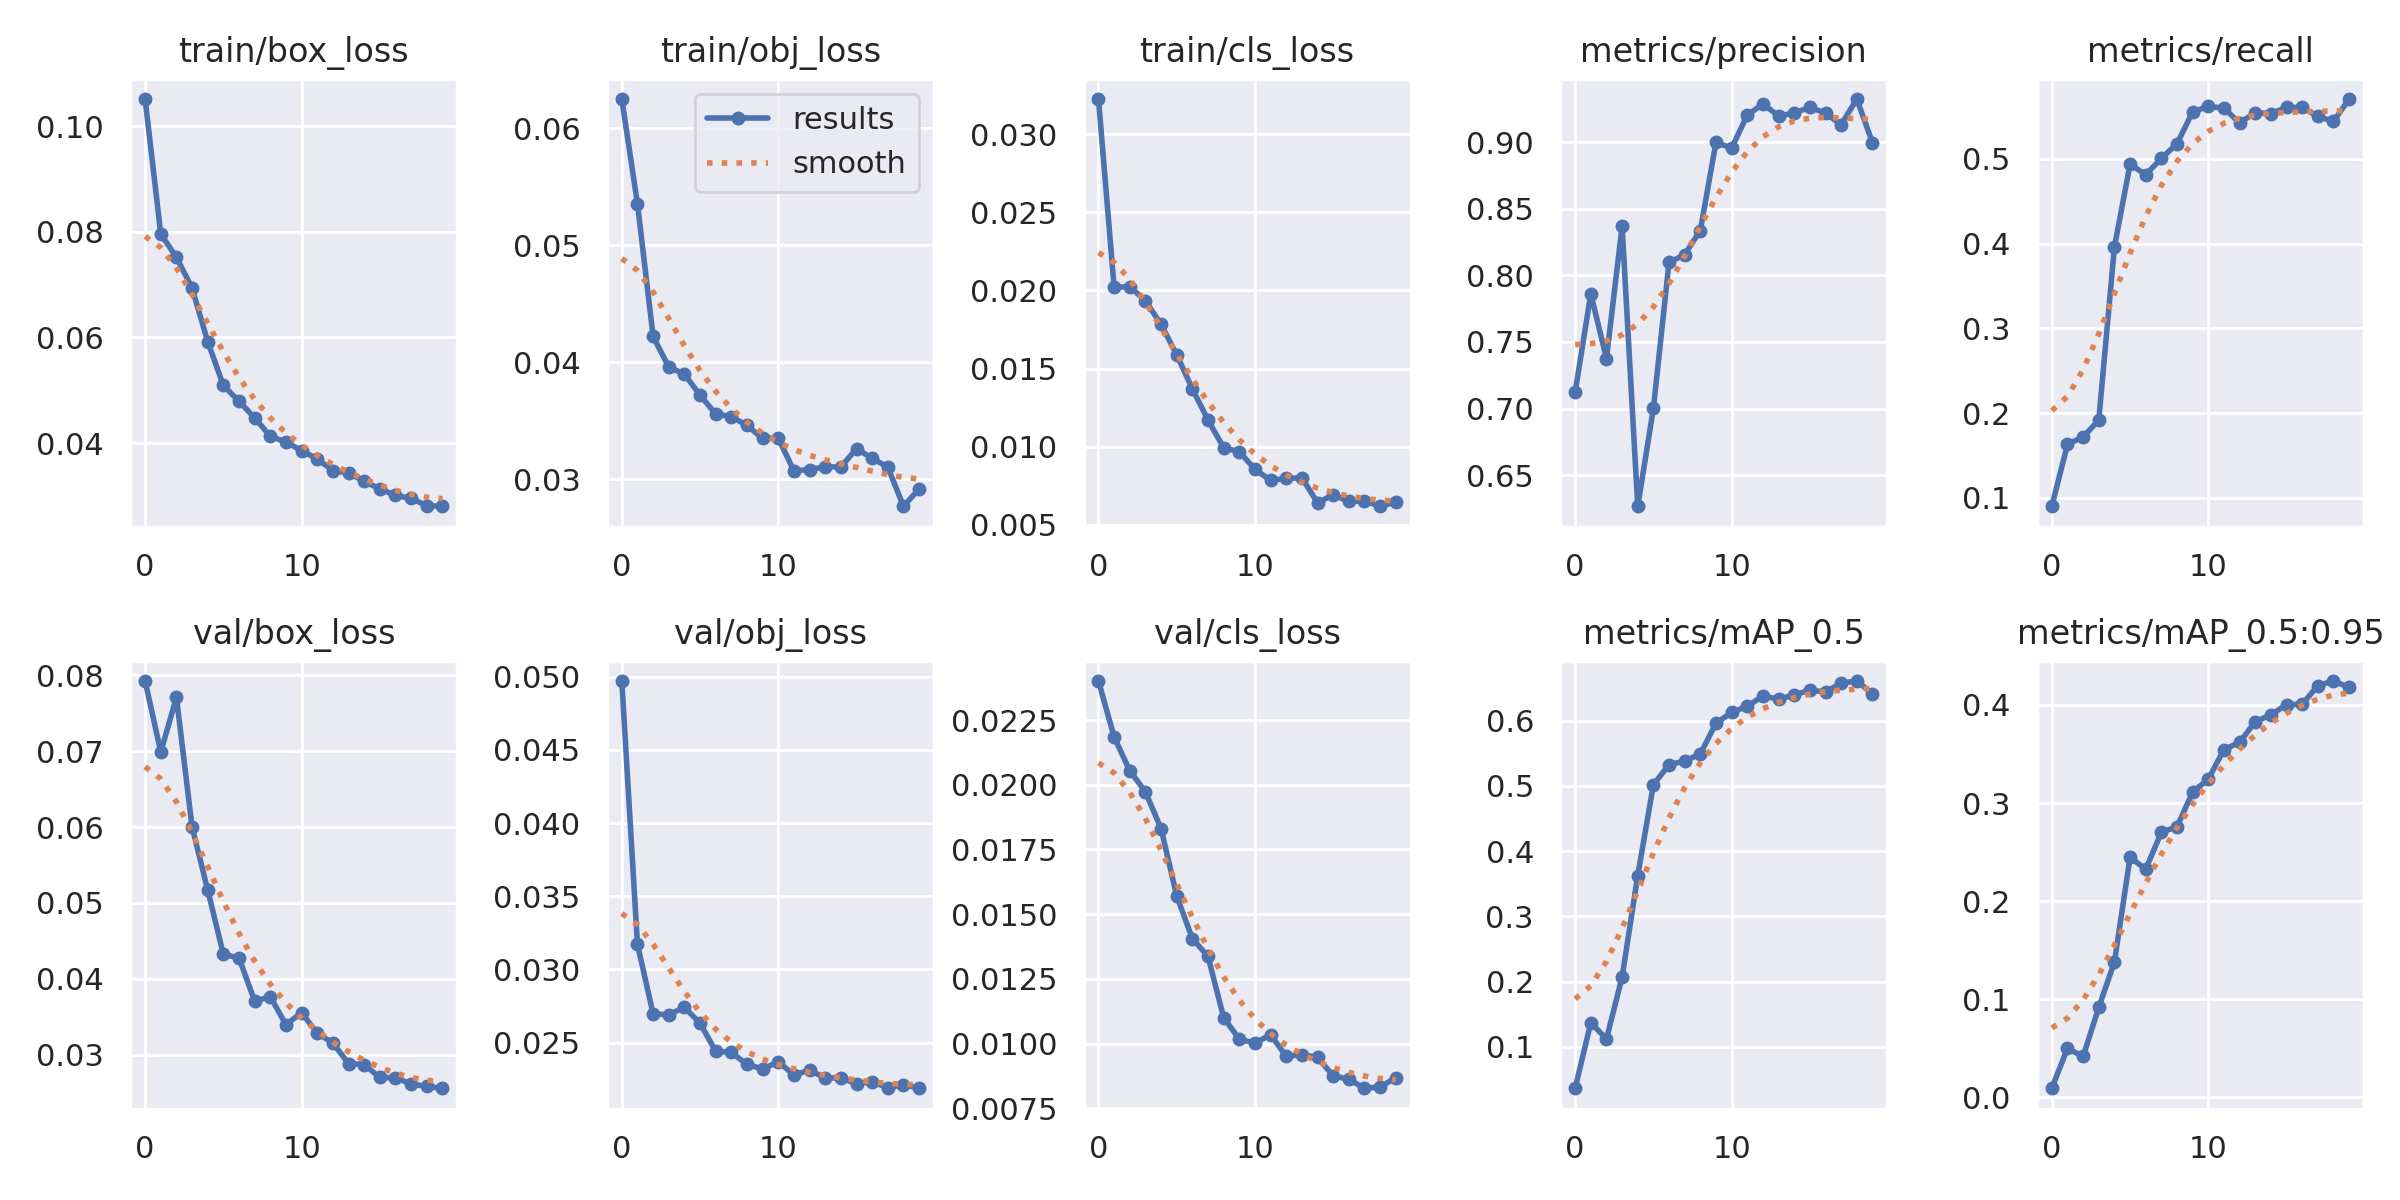

In [21]:
from IPython.display import Image
Image(filename='runs/train/fmd/results.png')

# 2. Mencoba hasil training

Melakukan deteksi pada beberapa gambar pada dataset validation.

In [22]:
!python detect.py \
  --name fmd \
  --source ../dataset/images/validation \
  --weights runs/train/fmd/weights/best.pt \
  --img 640 \
  --line-thickness 1 \
  --conf-thres 0.5 \
  --iou-thres 0.5 \
  --exist-ok

detect: weights=['runs/train/fmd/weights/best.pt'], source=../dataset/images/validation, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=fmd, exist_ok=True, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-175-g5f11555 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/171 /content/drive/MyDrive/face_mask_detection/dataset/images/validation/maksssksksss100.png: 384x640 2 with_masks, 1 without_mask, 46.2ms
image 2/171 /content/drive/MyDrive/face_mask_detection/dataset/images/validation/maksssksksss103.png: 480x640 4 with_masks, 92.7ms
image 3/171 /content/drive/MyDrive/face_mask_detection/dataset

Menampilkan semua gambar hasil deteksi.

/content/drive/MyDrive/face_mask_detection/yolov5


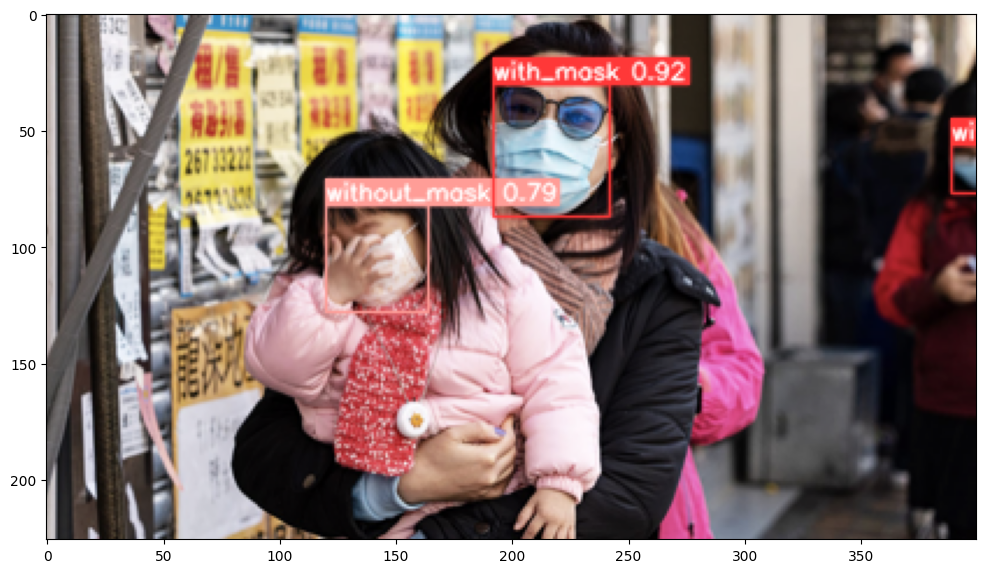

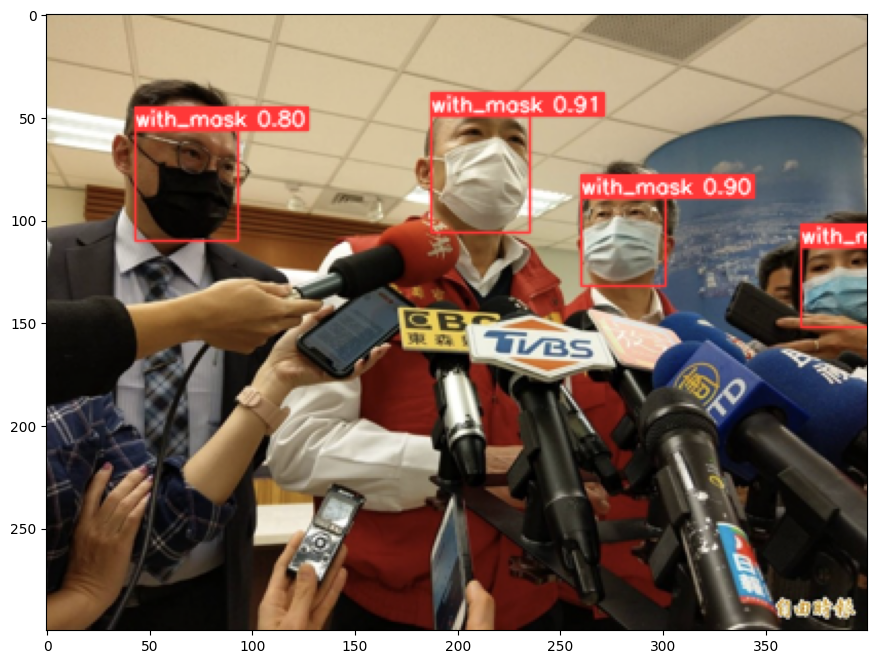

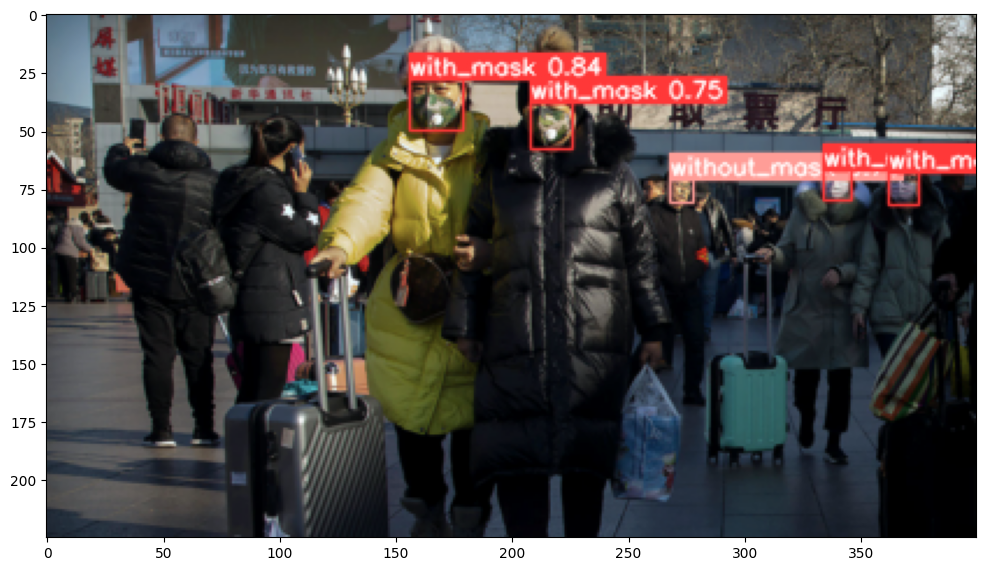

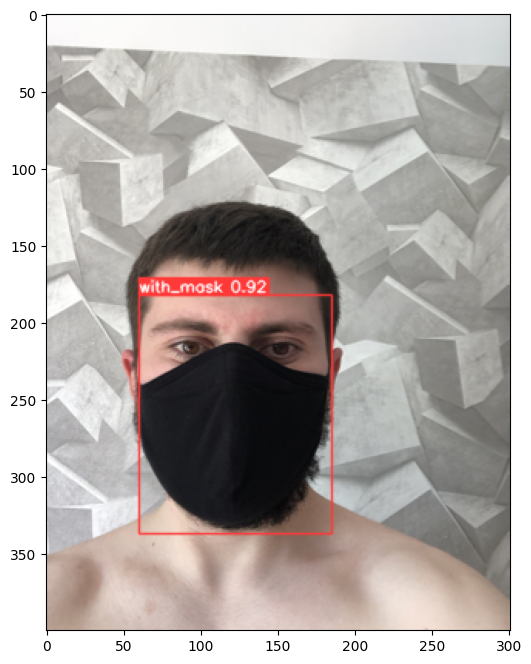

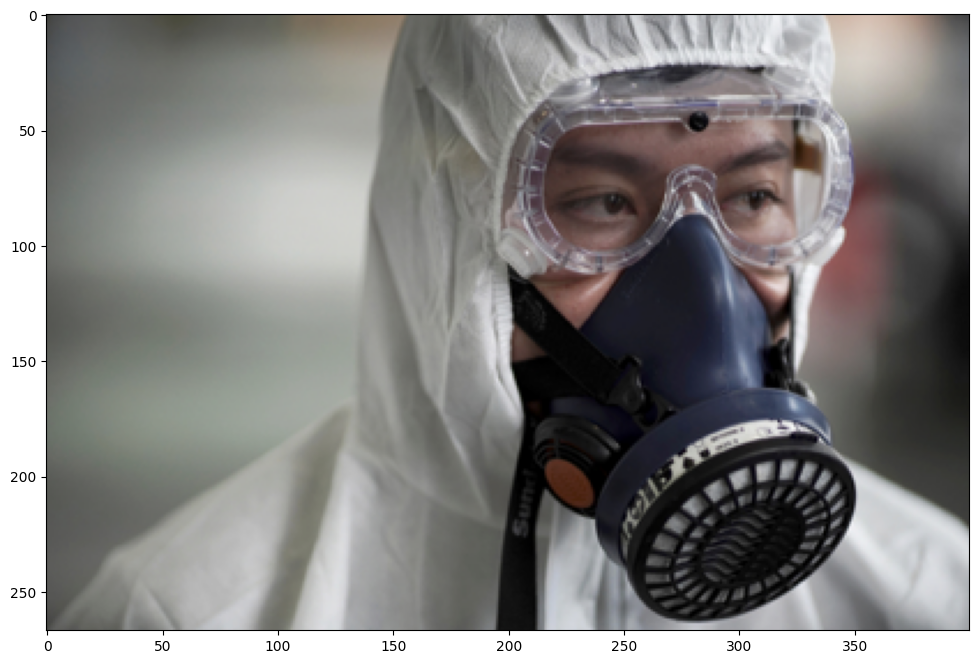

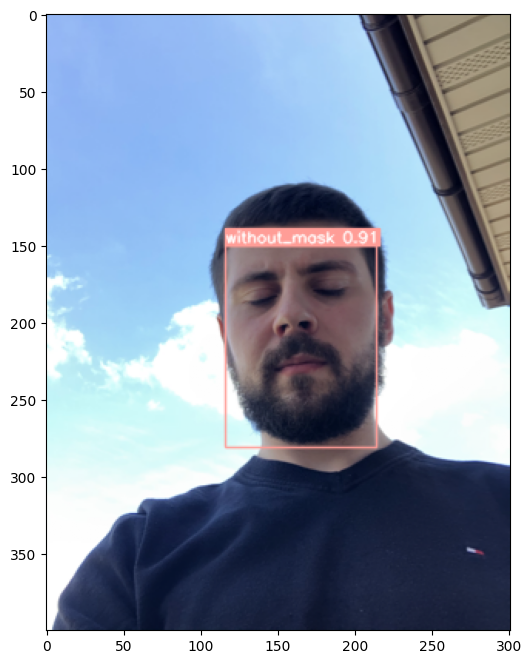

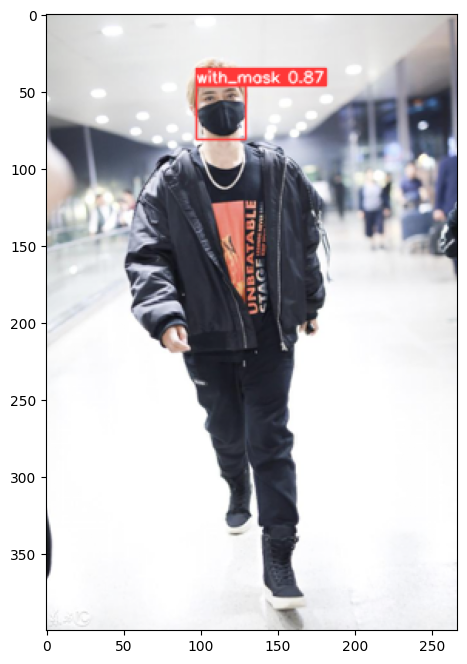

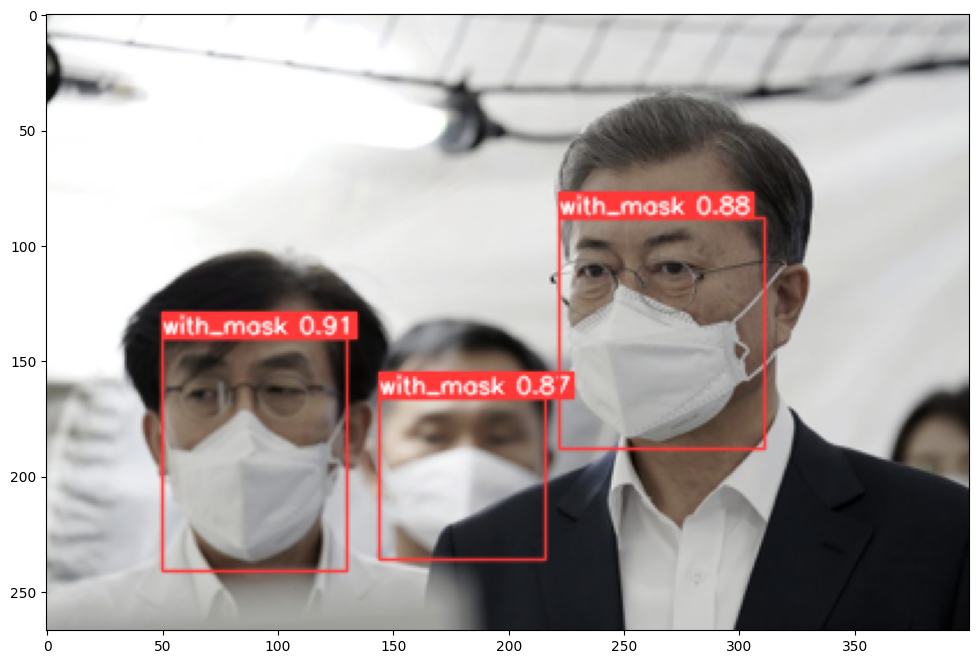

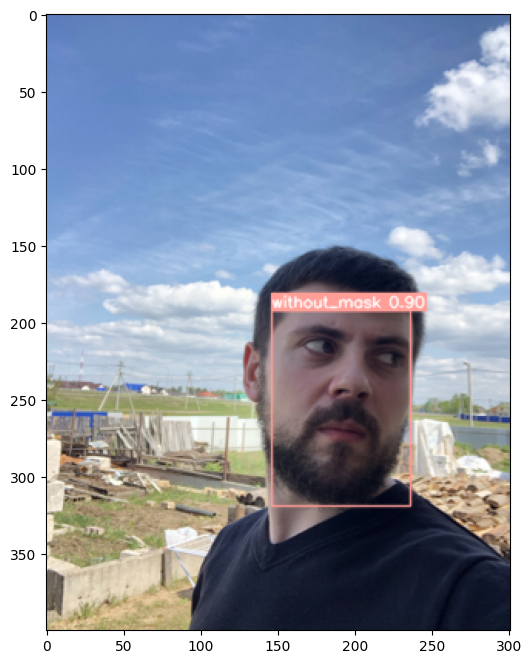

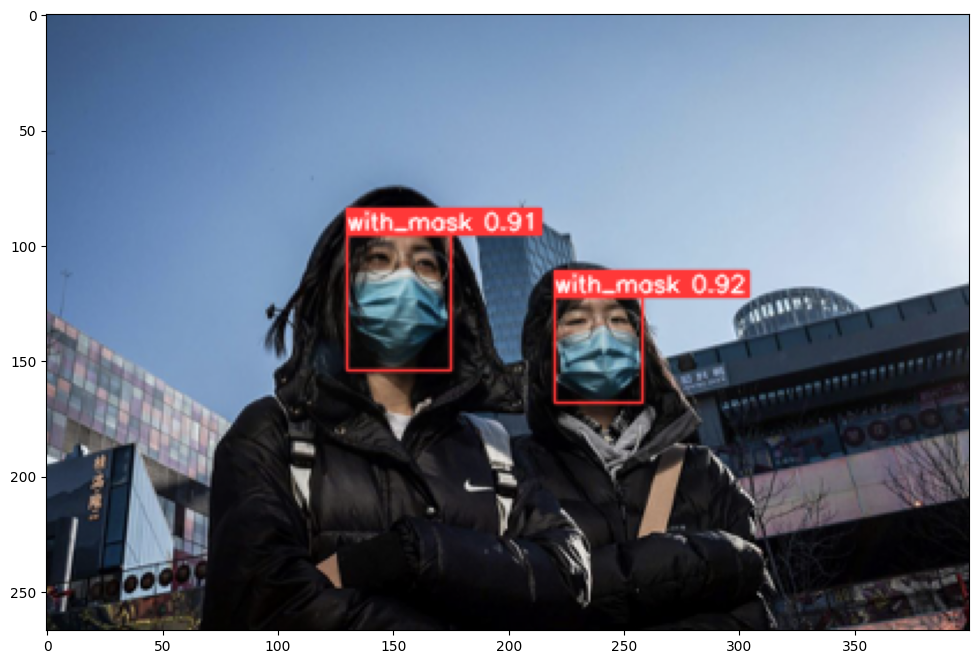

In [23]:
import matplotlib.pyplot as plt
from glob import glob

%cd /content/drive/MyDrive/face_mask_detection/yolov5

detection_paths = glob('runs/detect/fmd/*.png')

for path in detection_paths[:10]: # menampilkan hanya 10 hasil pertama
  img = plt.imread(path)
  plt.figure(figsize=(12, 8))
  plt.imshow(img)

plt.show()

Mencoba deteksi masker langsung dengan webcam

In [25]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg
detect: weights=['runs/train/fmd/weights/best.pt'], source=photo.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.5, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=fmd_camera, exist_ok=True, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-175-g5f11555 Python-3.10.11 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/face_mask_detection/yolov5/photo.jpg: 480x640 1 without_mask, 44.1ms
Speed: 0.5ms pre-process, 44.1ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/fmd_camera


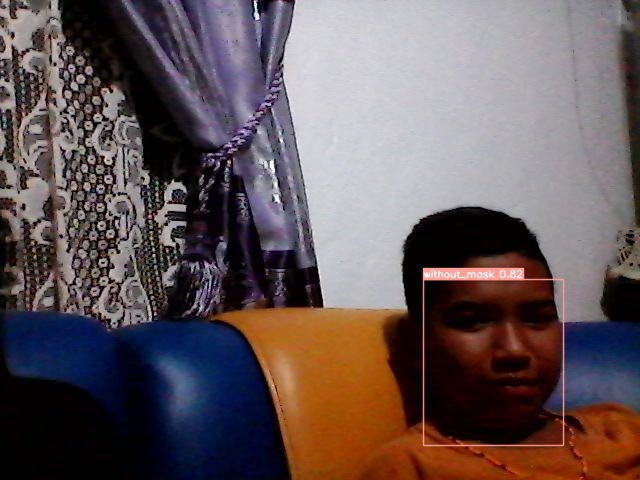

In [29]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  !python detect.py \
    --source {filename} \
    --name fmd_camera \
    --weights runs/train/fmd/weights/best.pt \
    --img 640 \
    --line-thickness 1 \
    --conf-thres 0.5 \
    --iou-thres 0.5 \
    --exist-ok
  
  # Show the image which was just taken.
  display(Image(f'runs/detect/fmd_camera/{filename}'))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))